<a href="https://colab.research.google.com/github/shivammehta007/NLPResearch/blob/master/Tutorials/Generative%20Models/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Writing A Variational Encoder in PyTorch
First Lets Import all the libraries needed

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Loading the Data, Lets use our favourite dataset MNIST

In [0]:
transformer = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(root='.data/', train=True, download=True, transform=transformer)
test_data = datasets.MNIST(root='.data/',train=False, download=True, transform=transformer)

Initializing Data Set Iterators for easy and batched access

In [0]:
BATCH_SIZE = 64

train_iterator = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_data, batch_size=BATCH_SIZE)


Now Lets Define the HyperParameters of our VAE 
Since, VAE is nothing but a combination of Autoencoders, lets define how our architecture will look like

* size of each input
* hidden dimension
* latent vector dimension
* learning rate      

In [0]:
INPUT_DIM = 28 * 28
HIDDEN_DIM = 256
LATENT_DIM = 20
lr = 1e-3

In VAE we have one Encoder $ q_\phi (z | x) $ , Lets first define that

In [0]:
class Encoder(nn.Module):
    '''
        This is the Encoder of VAE
    '''
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):

        hidden = F.relu(self.linear(x))
        mu_z = self.mu(hidden)
        var_z = self.var(hidden)

        return mu_z, var_z


Now, Lets Code Decoder $ p_\theta (x | z) $  which will take latent as input and give generated image as output 

In [0]:
class Decoder(nn.Module):
    '''
        This is the Decoder part of VAE
    '''
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        hidden = F.relu(self.linear(x))
        output = torch.sigmoid(self.out(hidden))
    
        return output

Now we have both our encoder and decoder, Lets write the final architecture of our VAE


In [0]:
class VAE(nn.Module):
    def __init__(self, enc, dec):
        super(VAE, self).__init__()
        self.encoder = enc
        self.decoder = dec
    
    def sampling(self, mu, var):
        std = torch.exp(var / 2)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):


        mu_z, var_z = self.encoder(x)

        x_sample = self.sampling(mu_z, var_z)
    
        prediction = self.decoder(x_sample)

        return prediction, mu_z, var_z
        

Lets, Initialize the Model

In [0]:
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

model = VAE(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

So we know that the LOSS of VAE is the Reconstruction loss and KL Divergence
So final loss function will give be = RL + KL


In [0]:
def reconstruction_loss(sampled_input, original_input):
    return F.binary_cross_entropy(sampled_input, original_input, size_average=False)

def kl_divergence(mu_z, var_z):
    return 0.5 * torch.sum(torch.exp(var_z) + mu_z**2 - 1.0 - var_z)

Lets now Train the Model 

In [0]:
def train(model, iterator, optimizer):
    model.train()

    train_loss = 0

    for i, (x, _) in enumerate(iterator):
        # Update the size of array
        x = x.view(-1, INPUT_DIM).to(device)

        # Forward Prop
        x_sample, mu_z, var_z = model(x)

        # Calculating Loss
        loss = reconstruction_loss(x_sample, x) + kl_divergence(mu_z, var_z)

        # Backpropagate
        loss.backward()

        # Update Train_loss
        train_loss += loss.item()

        optimizer.step()
    
    return train_loss



In [0]:
def test(model, iterator, optimizer):
    model.eval()

    test_loss = 0

    with torch.no_grad():
        for i, (x, _) in enumerate(iterator):
            x = x.view(-1, INPUT_DIM).to(device)

            x_sample, mu_z, var_z = model(x)

            loss = reconstruction_loss(x_sample, x) + kl_divergence(mu_z, var_z)

            test_loss += loss.item()
    
    return test_loss

        

In [0]:
N_EPOCHS = 20

Finally Training the Model with iterators and dataset

In [14]:
 for epoch in range(N_EPOCHS):

        train_loss = train(model, train_iterator, optimizer)
        test_loss = test(model, test_iterator, optimizer)

        train_loss /= len(train_data)
        test_loss /= len(test_data)

        print('Epoch :{}, Train_loss : {} Test_loss: {}'.format(epoch + 1, train_loss, test_loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch :1, Train_loss : 247.691322648112 Test_loss: 225.584222265625
Epoch :2, Train_loss : 227.8959071126302 Test_loss: 230.0393634765625
Epoch :3, Train_loss : 235.24255581054686 Test_loss: 242.44127458496095
Epoch :4, Train_loss : 239.46109811197917 Test_loss: 238.11618540039063
Epoch :5, Train_loss : 232.37769921061198 Test_loss: 227.071475390625
Epoch :6, Train_loss : 224.911977734375 Test_loss: 224.69393198242187
Epoch :7, Train_loss : 227.88393933105468 Test_loss: 230.19263952636717
Epoch :8, Train_loss : 230.1887731282552 Test_loss: 230.05522958984375
Epoch :9, Train_loss : 228.1150557779948 Test_loss: 226.16292204589843
Epoch :10, Train_loss : 227.5982838297526 Test_loss: 228.75995822753907
Epoch :11, Train_loss : 230.84038704427084 Test_loss: 233.88991337890624
Epoch :12, Train_loss : 234.70716589355467 Test_loss: 234.54342807617186
Epoch :13, Train_loss : 233.82448494466146 Test_loss: 231.7353688232422
Epoch :14, Train_loss : 231.02353225097656 Test_loss: 231.79360141601563
E

torch.Size([1, 20])
torch.Size([28, 28])


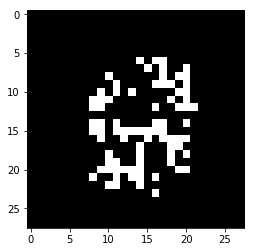

In [15]:
z = torch.randn(1, LATENT_DIM).to(device)

# run only the decoder
reconstructed_img = model.decoder(z)
img = reconstructed_img.view(28, 28).data

print(z.shape)
print(img.shape)
plt.imshow(img.cpu(), cmap='gray')